# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Testing multilabel algorithms
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

### Referencias:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Montando Google Drive


In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = 'drive/MyDrive/TesisMV'
except:
    root_dir = '..'
    
import os

## Selección de dataset y modelos

In [2]:
#modify only this cell
USE_RN50 = False
SUBCHAPTERS = False
ARCHITECTURE = 'resnet' 
DS_FLAGS = [] 
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
NUM_LABELS = 22
K = 4

In [3]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

subchapter_str = 'subchapters' if SUBCHAPTERS else ''
Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    patterns_dir = os.path.join(root_dir, 'patterns', subchapter_str + data_flags, str(i))
    labels_dir = os.path.join(root_dir, 'labels', subchapter_str + data_flags, str(i))
    exp_name = f'resnet50_K{i}' if USE_RN50 else f'resnet18_K{i}'
    rn = 50 if USE_RN50 else 18
    features_dir = os.path.join(root_dir, 'features', ARCHITECTURE, subchapter_str + data_flags, exp_name)
    
    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
    if not (os.path.isdir(features_dir)):
        print(features_dir)
        raise FileNotFoundError(f"""
        No se encontraron features para el conjunto de flags seleccionado. 
        Verifique que existan y, de lo contrario, llame a Feature Extraction
        """)
                                
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'features_dir': features_dir
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("--Features set encontrado en {}".format(features_dir))
    print("")

#../features/resnet/resnet50_base/
#../labels/base/
#Features set encontrado en ../features/resnet/resnet50_base/
#Labels set encontrado en ../labels/base/

Fold  0
--Pattern set encontrado en ..\patterns\base\0
--Labels set encontrado en ..\labels\base\0
--Features set encontrado en ..\features\resnet\base\resnet18_K0

Fold  1
--Pattern set encontrado en ..\patterns\base\1
--Labels set encontrado en ..\labels\base\1
--Features set encontrado en ..\features\resnet\base\resnet18_K1

Fold  2
--Pattern set encontrado en ..\patterns\base\2
--Labels set encontrado en ..\labels\base\2
--Features set encontrado en ..\features\resnet\base\resnet18_K2

Fold  3
--Pattern set encontrado en ..\patterns\base\3
--Labels set encontrado en ..\labels\base\3
--Features set encontrado en ..\features\resnet\base\resnet18_K3



In [4]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
import pickle

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Embedding classifiers
#from skmultilearn.embedding import OpenNetworkEmbedder, CLEMS, SKLearnEmbedder
#from sklearn.manifold import SpectralEmbedding
#from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
#from skmultilearn.embedding import EmbeddingClassifier
#from sklearn.ensemble import RandomForestRegressor

from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

# Procesamiento

In [6]:
print("Iniciando revisión de datasets")
for i in range(0, K):
    fold = Kfolds[i]
    print("Fold ", i)
    features_dir = fold['features_dir']
    labels_dir = fold['labels_dir']
    features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
    features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
    features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')

    assert features_train.shape[1] == features_test.shape[1] == features_val.shape[1]
    assert features_test.shape[0] == 194
    assert features_val.shape[0] == 78
    print(f"--Utilizando descriptores de dimensión {features_train.shape[1]}")

    labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
    labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
    labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

    assert labels_train.shape[1] == labels_test.shape[1] == labels_val.shape[1]
    assert labels_test.shape[0] == 194
    assert labels_val.shape[0] == 78
    print(f"--Los archivos de etiquetas contienen {labels_train.shape[1]} etiquetas distintas.")
    print("Fold aprobado.")
    print()

Iniciando revisión de datasets
Fold  0
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  1
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  2
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  3
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.



# Data exploration

In [7]:
k = 0 # cambiar para explorar otros folds
print(f"Explorando fold {k}")
fold = Kfolds[k]
labels_dir = fold['labels_dir']
labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

train_columns = labels_train.columns.values
labels_75f = labels_train.loc[['75f']].values
print('Etiquetas 75f: ' + ''.join(np.where(labels_75f == 1, train_columns, '')[0]))

explorer = DataExplorer(labels_train, labels_val, labels_test)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')

Explorando fold 0
Etiquetas 75f: horizontalpanelconcentriccircle
Number of unique labels combinations in all: 587
Label cardinality in all: 5.314432989690746
Label density in all: 0.006848496120735498


# Funciones auxiliares

In [8]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    return clf_predictions

# Benchmark


In [9]:
TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"BRkNN": brknna, "MLkNN": mlknn, "MLTSVM": mltsvm}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC(), "DT": tree.DecisionTreeClassifier(), "GNB": GaussianNB()}

In [10]:
#LABELS_IN_STUDY = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
LABELS_IN_STUDY = [5]
#for i in range(26, 300, 10):
#    LABELS_IN_STUDY.append(i)

exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}
exp_f1 = {}
exp_precision = {}
exp_recall = {}
exp_acc = {}
exp_5mr = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss[meth_name + "_" + base_name] = []
    exp_f1[meth_name + "_" + base_name] = []
    exp_precision[meth_name + "_" + base_name] = []
    exp_recall[meth_name + "_" + base_name] = []
    exp_acc[meth_name + "_" + base_name] = []
    exp_5mr[meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss[meth_name] = []
  exp_f1[meth_name] = []
  exp_precision[meth_name] = []
  exp_recall[meth_name] = []
  exp_acc[meth_name] = []
  exp_5mr[meth_name] = []

PREVIOUS_LABELS = 0
USED_FREQS = []

output_dir = os.path.join(root_dir, 'outputs', ARCHITECTURE, 
                           subchapter_str + data_flags, f'{min(LABELS_IN_STUDY)}-{max(LABELS_IN_STUDY)}L')

os.makedirs(output_dir, exist_ok = True)

for i in LABELS_IN_STUDY:
  pruner = KunischPruner(i)
  print("Comenzando con i={}".format(i))
    
  # Carga o generacion de top labels
  top_labels = None
  if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{i}L.pickle')):
        save = input(f"Se creará un archivo nuevo para {i} labels con el fold 0. Desea continuar? (y/n)")
        if save == "y":
            labels_dir = Kfolds[0]['labels_dir']
            train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
            top_labels = pruner.filter_labels(train_labels)
            with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'wb') as f:
                pickle.dump(top_labels, f)
            print("Top labels creado con éxito")
        else:
            raise Exception("No se logró cargar top_labels")
  else:
        print(f"Usando top_labels previamente generados para {i} labels")
        with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'rb') as f:
            top_labels = pickle.load(f)
        print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")
  
  pruner.set_top_labels(top_labels)
        
  if len(top_labels) == PREVIOUS_LABELS:
        print(f"Al intentar usar {i} labels, se repitió el valor previo {PREVIOUS_LABELS}. Saltando iteración.")
        continue
        
  PREVIOUS_LABELS = len(top_labels)
  USED_FREQS.append(i)
  

  for meth_name, method in ADAPT_METHODS.items():
        print("-Probando suerte con", meth_name)

        sum_f1 = 0
        sum_recall = 0
        sum_precision = 0
        sum_acc = 0
        sum_hl = 0
        sum_emr = 0
        sum_hs = 0
        sum_mr5 = 0

        # Iterate over folds
        for i in range(0, K):
            print(f"--Trabajando fold {i}")
            fold = Kfolds[i]
            features_dir = fold['features_dir']
            labels_dir = fold['labels_dir']
            features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
            features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
            features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
            labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
            labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
            labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
            
            #features_test = pd.concat([features_val, features_test])
            #labels_test = pd.concat([labels_val, labels_test])
            
            # Dataset creation
            X_train = features_train
            X_test = features_test   
            Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
            Y_test = pruner.filter_df(labels_test) # in both train and test

            predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
            metrics = KunischMetrics(Y_test.values, predictions_i)

            micro_f1 = metrics.get_f1(average='micro')
            micro_recall = metrics.get_recall(average='micro')
            micro_precision = metrics.get_precision(average='micro')
            acc = metrics.get_accuracy()
            hl = metrics.get_hamming_loss()
            emr = metrics.get_emr()
            hs = metrics.get_hamming_score()
            mr5 = metrics.k_match_ratio()

            print("---Micro F1:", micro_f1)
            print("---Micro recall:", micro_recall)
            print("---Micro precision:", micro_precision)
            print("---Accuracy:", acc)
            print("---Hamming Loss:", hl)
            print("---Exact Match Ratio:", emr)
            print("---Hamming Score:", hs)
            print("---5-Match Ratio:", mr5)

            sum_f1 += micro_f1
            sum_recall += micro_recall
            sum_precision += micro_precision
            sum_acc += acc
            sum_hl += hl 
            sum_emr += emr
            sum_hs += hs
            sum_mr5 += mr5
            print("")

        avg_f1 = round(sum_f1/K, 4)
        avg_recall = round(sum_recall/K, 4)
        avg_precision = round(sum_precision/K, 4)
        avg_acc = round(sum_acc/K, 4)
        avg_hl = round(sum_hl/K, 4)
        avg_emr = round(sum_emr/K, 4)
        avg_hs = round(sum_hs/K, 4)
        avg_mr5 = round(sum_mr5/K, 4)
        
        print("---AVG Micro F1:", avg_f1)
        print("---AVG Micro recall:", avg_recall)
        print("---AVG Micro precision:", avg_precision)
        print("---AVG Accuracy:", avg_acc)
        print("---AVG Hamming Loss:", avg_hl)
        print("---AVG Exact Match Ratio:", avg_emr)
        print("---AVG Hamming Score:", avg_hs)
        print("---AVG 5-Match Ratio:", avg_mr5)
            
        exp_exact_match[meth_name].append(avg_emr)
        exp_hscore[meth_name].append(avg_hs)
        exp_hloss[meth_name].append(avg_hl)
        exp_precision[meth_name].append(avg_precision)
        exp_recall[meth_name].append(avg_recall)
        exp_f1[meth_name].append(avg_f1)
        exp_acc[meth_name].append(avg_acc)
        exp_5mr[meth_name].append(avg_mr5)
        print("")
        
  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
        for base_name, classifier in BASE_CLASSIFIERS.items():
            print("-Probando suerte con", meth_name, base_name)

            sum_f1 = 0
            sum_recall = 0
            sum_precision = 0
            sum_acc = 0
            sum_hl = 0
            sum_emr = 0
            sum_hs = 0
            sum_mr5 = 0

            # Iterate over folds
            for i in range(0, K):
                print(f"--Trabajando fold {i}")
                fold = Kfolds[i]
                features_dir = fold['features_dir']
                labels_dir = fold['labels_dir']
                features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
                features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
                features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
                labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
                labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
                labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
                
                # Dataset creation
                X_train = features_train
                X_test = features_test   
                Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
                Y_test = pruner.filter_df(labels_test) # in both train and test
 
                predictions_i = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
                metrics = KunischMetrics(Y_test.values, predictions_i)

                micro_f1 = metrics.get_f1(average='micro')
                micro_recall = metrics.get_recall(average='micro')
                micro_precision = metrics.get_precision(average='micro')
                acc = metrics.get_accuracy()
                hl = metrics.get_hamming_loss()
                emr = metrics.get_emr()
                hs = metrics.get_hamming_score()
                mr5 = metrics.k_match_ratio()

                print("---Micro F1:", micro_f1)
                print("---Micro recall:", micro_recall)
                print("---Micro precision:", micro_precision)
                print("---Accuracy:", acc)
                print("---Hamming Loss:", hl)
                print("---Exact Match Ratio:", emr)
                print("---Hamming Score:", hs)
                print("---5-Match Ratio:", mr5)

                sum_f1 += micro_f1
                sum_recall += micro_recall
                sum_precision += micro_precision
                sum_acc += acc
                sum_hl += hl 
                sum_emr += emr
                sum_hs += hs
                sum_mr5 += mr5
                print("")

            avg_f1 = round(sum_f1/K, 4)
            avg_recall = round(sum_recall/K, 4)
            avg_precision = round(sum_precision/K, 4)
            avg_acc = round(sum_acc/K, 4)
            avg_hl = round(sum_hl/K, 4)
            avg_emr = round(sum_emr/K, 4)
            avg_hs = round(sum_hs/K, 4)
            avg_mr5 = round(sum_mr5/K, 4)

            print("---AVG Micro F1:", avg_f1)
            print("---AVG Micro recall:", avg_recall)
            print("---AVG Micro precision:", avg_precision)
            print("---AVG Accuracy:", avg_acc)
            print("---AVG Hamming Loss:", avg_hl)
            print("---AVG Exact Match Ratio:", avg_emr)
            print("---AVG Hamming Score:", avg_hs)
            print("---AVG 5-Match Ratio:", avg_mr5)

            exp_exact_match[meth_name + "_" + base_name].append(avg_emr)
            exp_hscore[meth_name + "_" + base_name].append(avg_hs)
            exp_hloss[meth_name + "_" + base_name].append(avg_hl)
            exp_precision[meth_name + "_" + base_name].append(avg_precision)
            exp_recall[meth_name + "_" + base_name].append(avg_recall)
            exp_f1[meth_name + "_" + base_name].append(avg_f1)
            exp_acc[meth_name + "_" + base_name].append(avg_acc)
            exp_5mr[meth_name + "_" + base_name].append(avg_mr5)
            print("")

for meth_name in exp_exact_match.keys():
    meth_results = {
        'accuracy': exp_acc[meth_name],
        'hamming_score': exp_hscore[meth_name],
        'hamming_loss': exp_hloss[meth_name],
        'f1_score': exp_f1[meth_name],
        'recall': exp_recall[meth_name],
        'precision': exp_precision[meth_name],
        'emr': exp_exact_match[meth_name],
        '5mr': exp_5mr[meth_name],
    }
    df = pd.DataFrame.from_dict(meth_results, orient='index')
    df.to_csv(os.path.join(output_dir, f'{meth_name}.csv'))

Comenzando con i=5
Usando top_labels previamente generados para 5 labels
top labels previamente generado contiene 5 etiquetas
-Probando suerte con BRkNN
--Trabajando fold 0
---Micro F1: 0.3786
---Micro recall: 0.391
---Micro precision: 0.3669
---Accuracy: 0.1856
---Hamming Loss: 0.3825
---Exact Match Ratio: 0.1856
---Hamming Score: 0.2049
---5-Match Ratio: 0.0

--Trabajando fold 1
---Micro F1: 0.33
---Micro recall: 0.3256
---Micro precision: 0.3345
---Accuracy: 0.134
---Hamming Loss: 0.4103
---Exact Match Ratio: 0.134
---Hamming Score: 0.1525
---5-Match Ratio: 0.0

--Trabajando fold 2
---Micro F1: 0.3552
---Micro recall: 0.3458
---Micro precision: 0.3651
---Accuracy: 0.134
---Hamming Loss: 0.4155
---Exact Match Ratio: 0.134
---Hamming Score: 0.1774
---5-Match Ratio: 0.0

--Trabajando fold 3
---Micro F1: 0.3391
---Micro recall: 0.3322
---Micro precision: 0.3463
---Accuracy: 0.1907
---Hamming Loss: 0.3938
---Exact Match Ratio: 0.1907
---Hamming Score: 0.186
---5-Match Ratio: 0.0

---AVG 

---Micro F1: 0.3798
---Micro recall: 0.3396
---Micro precision: 0.4308
---Accuracy: 0.1753
---Hamming Loss: 0.367
---Exact Match Ratio: 0.1753
---Hamming Score: 0.2045
---5-Match Ratio: 0.0

--Trabajando fold 3
---Micro F1: 0.4174
---Micro recall: 0.4237
---Micro precision: 0.4112
---Accuracy: 0.2113
---Hamming Loss: 0.3598
---Exact Match Ratio: 0.2113
---Hamming Score: 0.189
---5-Match Ratio: 0.0

---AVG Micro F1: 0.3918
---AVG Micro recall: 0.3772
---AVG Micro precision: 0.4099
---AVG Accuracy: 0.192
---AVG Hamming Loss: 0.3629
---AVG Exact Match Ratio: 0.192
---AVG Hamming Score: 0.191
---AVG 5-Match Ratio: 0.0

-Probando suerte con LP SVC
--Trabajando fold 0
---Micro F1: 0.4892
---Micro recall: 0.5087
---Micro precision: 0.4712
---Accuracy: 0.2629
---Hamming Loss: 0.3165
---Exact Match Ratio: 0.2629
---Hamming Score: 0.1881
---5-Match Ratio: 0.0

--Trabajando fold 1
---Micro F1: 0.4992
---Micro recall: 0.5083
---Micro precision: 0.4904
---Accuracy: 0.268
---Hamming Loss: 0.3165
---

D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


---Micro F1: 0.2976
---Micro recall: 0.2595
---Micro precision: 0.3488
---Accuracy: 0.1546
---Hamming Loss: 0.3649
---Exact Match Ratio: 0.1546
---Hamming Score: 0.1735
---5-Match Ratio: 0.0

--Trabajando fold 1


ValueError: Expected object or value

In [11]:
list(exp_hscore.values())

[[0.1987],
 [0.2061],
 [0.1926],
 [0.1855],
 [0.1912],
 [0.1918],
 [0.2084],
 [0.1871],
 [0.1895],
 [0.1989],
 [0.1922],
 [0.1867],
 [0.1992],
 [0.1972],
 [0.2024],
 [0.188],
 [0.2008],
 [0.2008],
 [0.2358]]

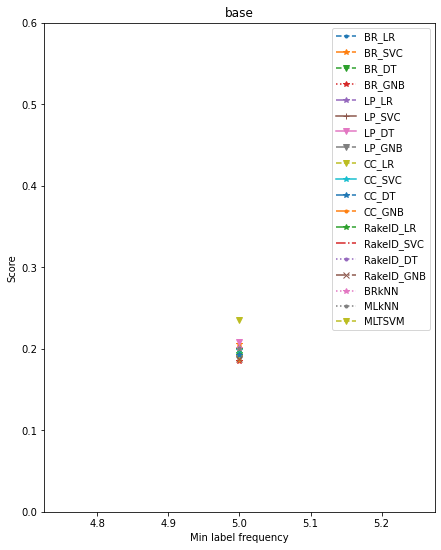

In [12]:
plotter = KunischPlotter()

plotter.plot_results(USED_FREQS,
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [45]:
top_labels

panel         266
horizontal    218
ornament      111
hatched       102
vertical       92
dtype: int64

In [46]:
for m, hl in zip(exp_exact_match.keys(), exp_hscore.values()):
    print(m, max(hl))

BR_LR 0.197
BR_SVC 0.1952
BR_DT 0.1831
BR_GNB 0.1898
LP_LR 0.1894
LP_SVC 0.1944
LP_DT 0.1934
LP_GNB 0.1891
CC_LR 0.1942
CC_SVC 0.1986
CC_DT 0.198
CC_GNB 0.1898
RakelD_LR 0.2034
RakelD_SVC 0.2017
RakelD_DT 0.2015
RakelD_GNB 0.1891
BRkNN 0.1979
MLkNN 0.1979
MLTSVM 0.2714


In [68]:
METHOD = "BR" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "LR" # | "SVC" | "DT" | "GNB" | "LR"
num_labels = 28

pruner = KunischPruner(num_labels)
top_labels = pruner.filter_labels(labels_train)
pruner.set_top_labels(top_labels)

print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = pruner.filter_df(labels_train)
X_test = features_test
Y_test = pruner.filter_df(labels_test)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

metrics = KunischMetrics(Y_test.values, predictions)

print("HAMMING SCORE: {}".format(metrics.get_hamming_score()))
predictions = predictions
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

Aplicando threshold 21 para trabajar con 28 labels
ATTENTION: TESTING WITH 28 LABELS
HAMMING SCORE: 0.1102
               precision    recall  f1-score   support

        panel       0.36      0.36      0.36        73
   horizontal       0.52      0.61      0.56        99
     ornament       0.33      0.02      0.04        44
      hatched       0.00      0.00      0.00        13
     vertical       0.00      0.00      0.00        25
       circle       0.00      0.00      0.00        17
      metopal       0.00      0.00      0.00        33
      lozenge       0.14      0.05      0.07        44
      filling       0.00      0.00      0.00        13
       double       0.00      0.00      0.00        33
    enclosing       0.14      0.06      0.08        35
cross-hatched       0.00      0.00      0.00        17
     triangle       0.00      0.00      0.00        12
   concentric       0.33      0.06      0.10        17
       dotted       0.00      0.00      0.00        12
        chai

In [62]:
print(Y_test.shape)
print(predictions.shape)

(194, 5)
(194, 5)


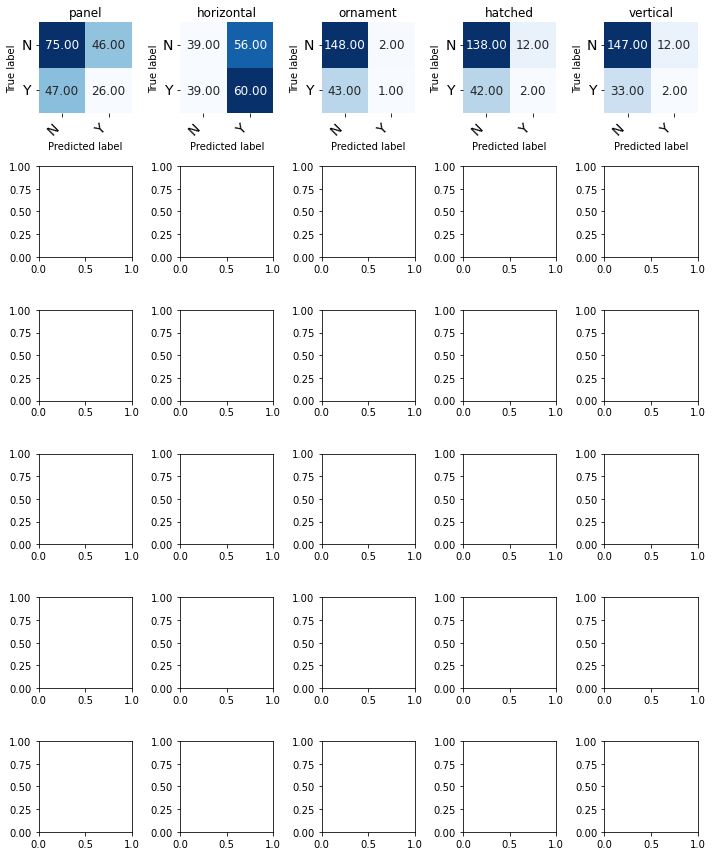

In [63]:
plotter = KunischPlotter()
plotter.plot_multiple_matrix(cfs_matrix, present_labels, nrows=6, ncols=5, figsize=(10,12), normalize=False)
#plot_multiple_matrix(cfs_matrix, present_labels, figsize=(10, 10))